# Fase 1: Ventana reducida con un subconjunto básico de features

### Datos:
- Time frame de 5M o 15M.
- Ventana de 60 velas.
- Features iniciales: Time (seno/coseno), OHLC, Volumen total (pretratado con la lógica descrita).

### Objetivo: 
Predecir el High.

### Entrenamiento: 
Entrenar el modelo Transformer hasta una convergencia razonable.

### Resultados esperados: 
El modelo aprende patrones básicos de precio y volumen en horizontes cortos.


## Pretratamiento

In [1]:
# Importamos las librerias 
import pandas as pd 
import numpy as np 
import json
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler 

import datetime as dt
import matplotlib.pyplot as plt

# La base de datos
from pymongo import MongoClient


import tensorflow as tf
import json
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

print("TensorFlow version:", tf.__version__)
print("GPUs disponibles: ", len(tf.config.experimental.list_physical_devices('GPU')))

2025-01-22 23:40:14.422539: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-22 23:40:14.422563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-22 23:40:14.423490: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-22 23:40:14.428300: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-22 23:40:14.962083: W tensorflow/compiler/tf2

TensorFlow version: 2.15.0
GPUs disponibles:  1


2025-01-22 23:40:15.387639: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-22 23:40:15.426465: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-22 23:40:15.429109: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
# Cargamos las funciones propias
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../Lib")
import MLfunctions_pretreatment as mlprt
import MLfunctions_predictions as mlpd
import MLfunctions_plot as mlplt

### Datos del ticker

In [3]:
# Fechas para la importacion de los datos. Vamos a incluir 2 años de datos para entrenar el modelo
start_date = dt.datetime(2022,6,1)
end_date = dt.datetime(2024,6,1)
# Importamos solo las columnas Time, Open, High, Low, Close, Volume y NewSession
columns=['Time','Open','High','Low','Close','Volume','NewSession']   
data=mlprt.get_data_ticker('ES', '5M', start_date, end_date, columns=columns) 

In [4]:
# Encontramos la primera nueva session
first_new_session = data[data['NewSession'] == True].iloc[0]
# Eliminamos las filas anteriores a la primera nueva session
data = data[data.index >= first_new_session.name]
data.head()

,Time,Open,High,Low,Close,Volume,NewSession
252,2022-06-01 22:00:00,4097.75,4099.00,4096.25,4098.00,1200,True
253,2022-06-01 22:05:00,4098.25,4098.50,4095.75,4096.50,351,False
254,2022-06-01 22:10:00,4096.50,4096.50,4093.75,4095.75,558,False
255,2022-06-01 22:15:00,4096.00,4099.50,4096.00,4098.00,663,False
256,2022-06-01 22:20:00,4098.00,4098.75,4093.75,4095.50,781,False


In [5]:
# Reiniciamos el indice
data = data.reset_index(drop=True)
data.head()

,Time,Open,High,Low,Close,Volume,NewSession
0,2022-06-01 22:00:00,4097.75,4099.00,4096.25,4098.00,1200,True
1,2022-06-01 22:05:00,4098.25,4098.50,4095.75,4096.50,351,False
2,2022-06-01 22:10:00,4096.50,4096.50,4093.75,4095.75,558,False
3,2022-06-01 22:15:00,4096.00,4099.50,4096.00,4098.00,663,False
4,2022-06-01 22:20:00,4098.00,4098.75,4093.75,4095.50,781,False


In [6]:
# Calculamos el ATR de 14 periodos. No se usa para Feature, pero si para ver correlaciones de la parte de prediccion
data['ATR'] = mlprt.calculate_atr(data,period=14)

## Features

### Time. Descomposicion en Seno y Coseno

In [7]:
# Time. Descomponemos la fecha en seno y coseno
data = mlprt.sincostime(data)

### Precios. Close, High y Low. Para la normalizacion se usa tambien Open, pero despues se elimina

In [8]:
# Moving Average. Calculamos la media movil de 10 periodos de Open, High, Low, Close
period = 10
data =mlprt.features_ma(data,period,features=['Open','High','Low','Close','Volume'])

# PCT Change. Calculamos el pct_change de 10 periodos de Open, High, Low, Close
data = mlprt.features_pct_change(data,period,features=['Open','High','Low','Close','Volume'])

### Indices de los conjuntos de entreamiento, validacion y test

In [9]:
# Eliminamos las filas con NaN
print('Eliminamos las filas con NaN')
print(f'Longitud de data antes de eliminar NaN: {len(data)}')
data.dropna(how='any', axis=0, inplace=True) 
data = data.reset_index(drop=True)
print(f'Longitud de data despues de eliminar NaN: {len(data)}')
print('-'*50)

Eliminamos las filas con NaN
Longitud de data antes de eliminar NaN: 141783
Longitud de data despues de eliminar NaN: 141773
--------------------------------------------------


In [10]:
# Indices de los sets de entrenamiento, validacion y test
validation_pct = 0.1
test_pct = 0.2  
index = mlprt.index_sets(data, validation_pct, test_pct)
print(f'El validation comienza en {index["start_val"]} y el test en {index["start_test"]}')
print('-'*50)
# Guardamos los valores de index en un archivo json
# Convertir valores numpy.int64 a int para hacerlos serializables
index = {key: int(value) if isinstance(value, np.integer) else value for key, value in index.items()}
with open('index_cl_f1.json', 'w') as f:
    json.dump(index, f)


El validation comienza en 113419 y el test en 127596
--------------------------------------------------


### Normalizacion

In [11]:
# Normalizacion
normalization_values = mlprt.normalization_values(data,index)

print('Valores de normalizacion de precios:')
print(f'Min: {normalization_values["min_price"]}')
print(f'Max: {normalization_values["max_price"]}')
print('-'*50)
print('Valores de normalizacion de volumen:')
print(f'Min: {normalization_values["min_volume"]}')
print(f'Max: {normalization_values["max_volume"]}')

Valores de normalizacion de precios:
Min: -0.0036812411847673143
Max: 0.003422238065917016
--------------------------------------------------
Valores de normalizacion de volumen:
Min: -0.8607483416252073
Max: 4.0901363905910255


In [12]:
# Guardamos los valores de normalizacion en un archivo json
with open('normalization_values_cl_f1.json', 'w') as f:
    json.dump(normalization_values, f)

In [13]:
data = mlprt.features_normalized(data,['Open','High','Low','Close'],normalization_values['min_price'],normalization_values['max_price'])
data = mlprt.features_normalized(data,['Volume'],normalization_values['min_volume'],normalization_values['max_volume'])

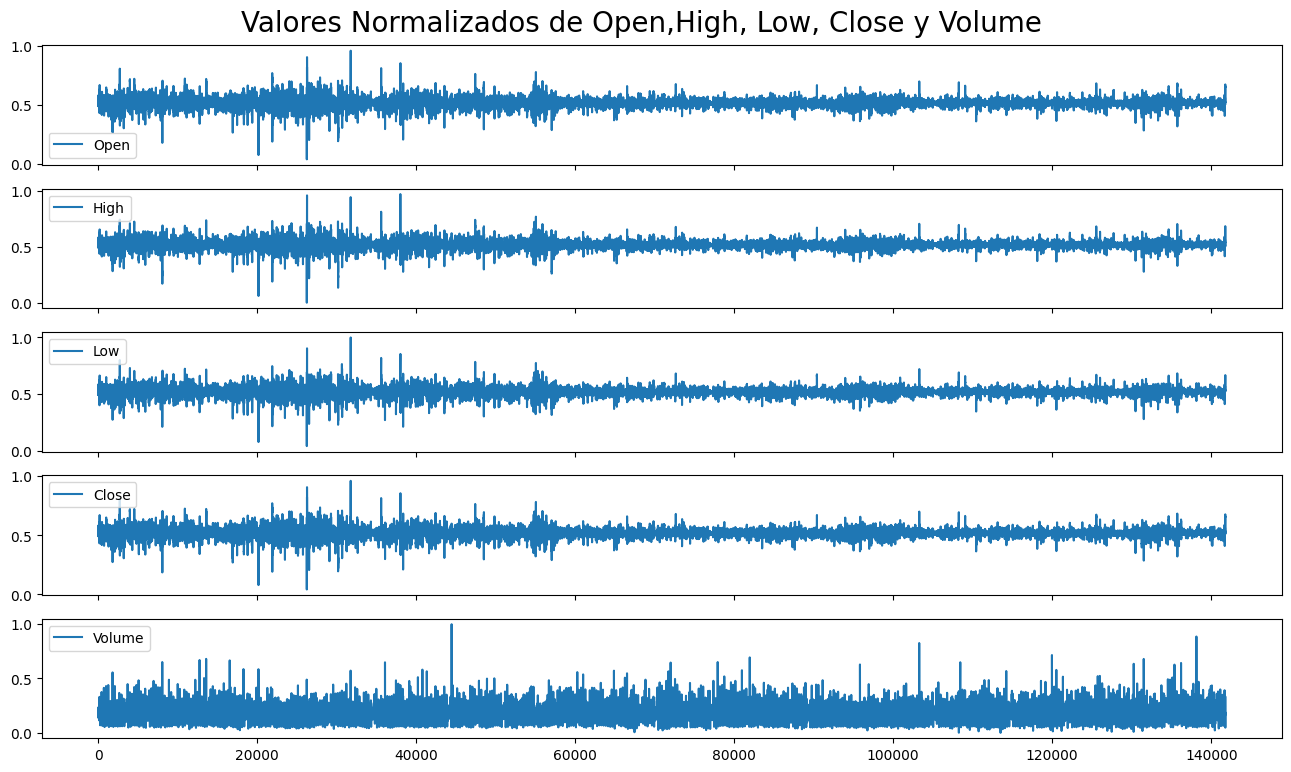

In [14]:
# Plot Close Price, Delta, Volume  in 3 rows
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, figsize=(16, 9), sharex=True)
st = fig.suptitle("Valores Normalizados de Open,High, Low, Close y Volume", fontsize=20)
st.set_y(0.92)
ax1.plot(data['Open_nor'], label='Open')
ax2.plot(data['High_nor'], label='High')
ax3.plot(data['Low_nor'], label='Low')
ax4.plot(data['Close_nor'], label='Close')
ax5.plot(data['Volume_nor'], label='Volume')

ax1.legend(loc='lower left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax4.legend(loc='upper left')
ax5.legend(loc='upper left')

plt.show()

### Selección del Target

In [15]:
# Hacemos el target_nor igual al valor a predecir
data['Target_nor'] = data['High_nor']

# Dataframe con las columnas que vamos a usar para entrenar al modelo, asegurandonos de que el target sea la ultima columna
df = data[['sin_time','cos_time','Open_nor','High_nor','Low_nor','Close_nor','Volume_nor','Target_nor']].copy()

# Guardamos el dataframe en un archivo csv
df.to_csv('df_cl_f1_high.csv', index=False)

#Guardamos el dataframe completo data en un archivo csv
data.to_csv('data_cl_f1_high.csv', index=False)   

## Preparacion de datos para el entrenamiento
Consideraciones:
- Ventana de contexto: 60 velas (5h)

In [16]:
# Aplicar la función para crear las secuencias
seq_length = 60  # 5h 
features_time = ['sin_time', 'cos_time']
features_price = ['Open_nor', 'High_nor', 'Low_nor', 'Close_nor']
features_volume = ['Volume_nor']
features_vp = []
target_column = 'Target_nor'

X_time, X_price, X_volume, X_vp, y = mlpd.create_sequences_transformer(df, seq_length, features_time, features_price, features_volume, features_vp, target_column)

In [17]:
# Dividir los datos X_time, X_price, X_volume, X_vp, y en conjuntos de training (0.7), validación (0.1) y test (0.2)

# Para ello dividimos los conjuntos orginales en training+validation (0.8) y test (0.2). Se selecciona random_state=42, shuffle=False para que los indices queden en el mismo orden que en el dataframe original.
X_time_train, X_time_test, X_price_train, X_price_test, X_volume_train, X_volume_test, X_vp_train, X_vp_test, y_train, y_test = train_test_split(X_time, X_price, X_volume, X_vp, y, test_size=0.2, random_state=42, shuffle=False)

# Segunda división: 87.5% entrenamiento, 12.5% validación (dentro del 80% de entrenamiento+validación). Ahora queda el training set en training (0.7) y validation (0.1) del total. Se selecciona random_state=42 para que los indices queden en el mismo orden que en el dataframe original.

X_time_train, X_time_val, X_price_train, X_price_val, X_volume_train, X_volume_val, X_vp_train, X_vp_val, y_train, y_val = train_test_split(X_time_train, X_price_train, X_volume_train, X_vp_train, y_train, test_size=0.125, random_state=42, shuffle=False)


print(f'X_time_train shape: {X_time_train.shape}')
print(f'X_time_val shape: {X_time_val.shape}')
print(f'X_time_test shape: {X_time_test.shape}')
print(f'X_price_train shape: {X_price_train.shape}')
print(f'X_price_val shape: {X_price_val.shape}')
print(f'X_price_test shape: {X_price_test.shape}')
print(f'X_volume_train shape: {X_volume_train.shape}')
print(f'X_volume_val shape: {X_volume_val.shape}')
print(f'X_volume_test shape: {X_volume_test.shape}')
print(f'X_vp_train shape: {X_vp_train.shape}')
print(f'X_vp_val shape: {X_vp_val.shape}')
print(f'X_vp_test shape: {X_vp_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')

X_time_train shape: (99197, 60, 2)
X_time_val shape: (14172, 60, 2)
X_time_test shape: (28343, 60, 2)
X_price_train shape: (99197, 60, 4)
X_price_val shape: (14172, 60, 4)
X_price_test shape: (28343, 60, 4)
X_volume_train shape: (99197, 60, 1)
X_volume_val shape: (14172, 60, 1)
X_volume_test shape: (28343, 60, 1)
X_vp_train shape: (99197, 60, 0)
X_vp_val shape: (14172, 60, 0)
X_vp_test shape: (28343, 60, 0)
y_train shape: (99197,)
y_val shape: (14172,)


### Arquitectura del Modelo

In [18]:
# Definir parámetros
num_features = 7  # Número de características después del preprocesamiento
d_model = 64  # Dimensión del modelo
num_heads = 4  # Número de cabezas en la atención múltiple, esta relacionado con el numero de agrupaciones que se hace en las features
ff_dim = 128  # Dimensión interna del feed-forward
num_layers = 2  # Número de capas del Transformer


# Definir entrada para los diferentes grupos de características
time_inputs = layers.Input(shape=(seq_length, 2))  # sin_time, cos_time
price_inputs = layers.Input(shape=(seq_length, 4))  # Open, High, Low, Close
volume_inputs = layers.Input(shape=(seq_length, 1))  # Volume


In [19]:
# Función para crear un bloque de Transformer para un grupo de características
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs  # Residual connection

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res  # Residual connection

In [20]:
# Bloques Transformer para cada grupo
time_transformer = transformer_block(time_inputs, head_size=d_model, num_heads=num_heads, ff_dim=ff_dim)
price_transformer = transformer_block(price_inputs, head_size=d_model, num_heads=num_heads, ff_dim=ff_dim)
volume_transformer = transformer_block(volume_inputs, head_size=d_model, num_heads=num_heads, ff_dim=ff_dim)

# Aplicar Global Average Pooling para cada grupo
time_pooled = layers.GlobalAveragePooling1D()(time_transformer)
price_pooled = layers.GlobalAveragePooling1D()(price_transformer)
volume_pooled = layers.GlobalAveragePooling1D()(volume_transformer)

# Concatenar las salidas de cada grupo
concatenated = layers.Concatenate()([time_pooled, price_pooled, volume_pooled])

# Capa Densa final
dense = layers.Dense(128, activation='relu')(concatenated)
outputs = layers.Dense(1)(dense)

# Modelo final
model = tf.keras.Model(inputs=[time_inputs, price_inputs, volume_inputs], outputs=outputs)

2025-01-22 23:40:23.675380: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-22 23:40:23.678063: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-22 23:40:23.680651: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Entrenamiento del modelo

In [21]:
# Compilar el modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60, 2)]              0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 60, 4)]              0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 60, 1)]              0         []                            
                                                                                                  
 layer_normalization (Layer  (None, 60, 2)                4         ['input_1[0][0]']             
 Normalization)                                                                               

In [22]:

# Definir parámetros del entrenamiento
epochs = 100
batch_size = 16
patience = 5  # Número de épocas sin mejora en validación antes de detener el entrenamiento

# Callbacks para guardar el mejor modelo y detener el entrenamiento temprano
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    'best_model',             # Ruta donde se guarda el mejor modelo
    monitor='val_loss',       # Métrica a monitorear
    save_best_only=True,      # Guardar solo el mejor modelo
    mode='min',               # Minimizar la métrica (val_loss)
    verbose=1,                # Muestra los comentarios del proceso
    save_format='tf'          # Se guarda en formato SavedModel disponile en Tensorflow 2.x
)


In [23]:
history = model.fit(
        [X_time_train, X_price_train, X_volume_train], 
        y_train, 
        epochs=epochs, 
        batch_size=batch_size, 
        validation_data=([X_time_val, X_price_val, X_volume_val], y_val), 
        callbacks=[early_stopping, checkpoint], 
        verbose=1
    )

Epoch 1/100


2025-01-22 23:40:27.083309: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2025-01-22 23:40:27.704954: I external/local_xla/xla/service/service.cc:168] XLA service 0x6ff8589a8c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-22 23:40:27.704970: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-01-22 23:40:27.709329: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737585627.755540  260031 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6200/6200 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0207
Epoch 1: val_loss improved from inf to 0.00028, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


6200/6200 [==============================] - 77s 11ms/step - loss: 0.0011 - mae: 0.0207 - val_loss: 2.7640e-04 - val_mae: 0.0105
Epoch 2/100
6198/6200 [============================>.] - ETA: 0s - loss: 8.8492e-04 - mae: 0.0192
Epoch 2: val_loss did not improve from 0.00028
6200/6200 [==============================] - 69s 11ms/step - loss: 8.8476e-04 - mae: 0.0192 - val_loss: 3.5532e-04 - val_mae: 0.0146
Epoch 3/100
6199/6200 [============================>.] - ETA: 0s - loss: 8.5084e-04 - mae: 0.0185
Epoch 3: val_loss did not improve from 0.00028
6200/6200 [==============================] - 70s 11ms/step - loss: 8.5074e-04 - mae: 0.0185 - val_loss: 2.7811e-04 - val_mae: 0.0115
Epoch 4/100
6199/6200 [============================>.] - ETA: 0s - loss: 8.4041e-04 - mae: 0.0182
Epoch 4: val_loss did not improve from 0.00028
6200/6200 [==============================] - 70s 11ms/step - loss: 8.4035e-04 - mae: 0.0182 - val_loss: 2.7772e-04 - val_mae: 0.0108
Epoch 5/100
6200/6200 [==============

INFO:tensorflow:Assets written to: best_model/assets


6200/6200 [==============================] - 71s 12ms/step - loss: 8.2988e-04 - mae: 0.0180 - val_loss: 2.7617e-04 - val_mae: 0.0112
Epoch 7/100
6200/6200 [==============================] - ETA: 0s - loss: 8.2656e-04 - mae: 0.0180
Epoch 7: val_loss did not improve from 0.00028
6200/6200 [==============================] - 69s 11ms/step - loss: 8.2656e-04 - mae: 0.0180 - val_loss: 3.9161e-04 - val_mae: 0.0145
Epoch 8/100
6200/6200 [==============================] - ETA: 0s - loss: 8.2459e-04 - mae: 0.0179
Epoch 8: val_loss improved from 0.00028 to 0.00027, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


6200/6200 [==============================] - 72s 12ms/step - loss: 8.2459e-04 - mae: 0.0179 - val_loss: 2.6963e-04 - val_mae: 0.0105
Epoch 9/100
6200/6200 [==============================] - ETA: 0s - loss: 8.1921e-04 - mae: 0.0178
Epoch 9: val_loss did not improve from 0.00027
6200/6200 [==============================] - 70s 11ms/step - loss: 8.1921e-04 - mae: 0.0178 - val_loss: 3.0625e-04 - val_mae: 0.0110
Epoch 10/100
6199/6200 [============================>.] - ETA: 0s - loss: 8.2001e-04 - mae: 0.0178
Epoch 10: val_loss improved from 0.00027 to 0.00026, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


6200/6200 [==============================] - 70s 11ms/step - loss: 8.2002e-04 - mae: 0.0178 - val_loss: 2.5778e-04 - val_mae: 0.0101
Epoch 11/100
6199/6200 [============================>.] - ETA: 0s - loss: 8.1664e-04 - mae: 0.0177
Epoch 11: val_loss did not improve from 0.00026
6200/6200 [==============================] - 69s 11ms/step - loss: 8.1656e-04 - mae: 0.0177 - val_loss: 3.0326e-04 - val_mae: 0.0124
Epoch 12/100
6199/6200 [============================>.] - ETA: 0s - loss: 8.1423e-04 - mae: 0.0177
Epoch 12: val_loss did not improve from 0.00026
6200/6200 [==============================] - 68s 11ms/step - loss: 8.1422e-04 - mae: 0.0177 - val_loss: 2.6073e-04 - val_mae: 0.0103
Epoch 13/100
6197/6200 [============================>.] - ETA: 0s - loss: 8.1131e-04 - mae: 0.0176
Epoch 13: val_loss did not improve from 0.00026
6200/6200 [==============================] - 68s 11ms/step - loss: 8.1131e-04 - mae: 0.0176 - val_loss: 2.6793e-04 - val_mae: 0.0100
Epoch 14/100
6197/6200 [===

INFO:tensorflow:Assets written to: best_model/assets


6200/6200 [==============================] - 69s 11ms/step - loss: 8.0931e-04 - mae: 0.0176 - val_loss: 2.5529e-04 - val_mae: 0.0099
Epoch 15/100
6196/6200 [============================>.] - ETA: 0s - loss: 8.0711e-04 - mae: 0.0175
Epoch 15: val_loss did not improve from 0.00026
6200/6200 [==============================] - 69s 11ms/step - loss: 8.0703e-04 - mae: 0.0175 - val_loss: 2.7208e-04 - val_mae: 0.0102
Epoch 16/100
6196/6200 [============================>.] - ETA: 0s - loss: 8.0499e-04 - mae: 0.0175
Epoch 16: val_loss improved from 0.00026 to 0.00025, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


6200/6200 [==============================] - 70s 11ms/step - loss: 8.0509e-04 - mae: 0.0175 - val_loss: 2.4797e-04 - val_mae: 0.0097
Epoch 17/100
6199/6200 [============================>.] - ETA: 0s - loss: 8.0475e-04 - mae: 0.0174
Epoch 17: val_loss did not improve from 0.00025
6200/6200 [==============================] - 68s 11ms/step - loss: 8.0468e-04 - mae: 0.0174 - val_loss: 2.5226e-04 - val_mae: 0.0101
Epoch 18/100
6199/6200 [============================>.] - ETA: 0s - loss: 8.0283e-04 - mae: 0.0174
Epoch 18: val_loss did not improve from 0.00025
6200/6200 [==============================] - 68s 11ms/step - loss: 8.0289e-04 - mae: 0.0174 - val_loss: 2.4985e-04 - val_mae: 0.0097
Epoch 19/100
6196/6200 [============================>.] - ETA: 0s - loss: 8.0093e-04 - mae: 0.0174
Epoch 19: val_loss did not improve from 0.00025
6200/6200 [==============================] - 68s 11ms/step - loss: 8.0089e-04 - mae: 0.0174 - val_loss: 2.7061e-04 - val_mae: 0.0102
Epoch 20/100
6198/6200 [===

INFO:tensorflow:Assets written to: best_model/assets


6200/6200 [==============================] - 70s 11ms/step - loss: 7.9905e-04 - mae: 0.0173 - val_loss: 2.4600e-04 - val_mae: 0.0095
Epoch 21/100
6200/6200 [==============================] - ETA: 0s - loss: 7.9971e-04 - mae: 0.0173
Epoch 21: val_loss did not improve from 0.00025
6200/6200 [==============================] - 69s 11ms/step - loss: 7.9971e-04 - mae: 0.0173 - val_loss: 2.5524e-04 - val_mae: 0.0100
Epoch 22/100
6200/6200 [==============================] - ETA: 0s - loss: 7.9898e-04 - mae: 0.0173
Epoch 22: val_loss did not improve from 0.00025
6200/6200 [==============================] - 68s 11ms/step - loss: 7.9898e-04 - mae: 0.0173 - val_loss: 2.6041e-04 - val_mae: 0.0100
Epoch 23/100
6197/6200 [============================>.] - ETA: 0s - loss: 7.9902e-04 - mae: 0.0173
Epoch 23: val_loss did not improve from 0.00025
6200/6200 [==============================] - 68s 11ms/step - loss: 7.9880e-04 - mae: 0.0173 - val_loss: 2.6277e-04 - val_mae: 0.0102
Epoch 24/100
6198/6200 [===

In [31]:
# Guardamos el modelo
model.save("CL_F1_High_1", save_format='tf')
history_json = json.dumps(history.history)
with open('history_CL_F1_High_1.json', 'w') as json_file:
    json_file.write(history_json)

INFO:tensorflow:Assets written to: CL_F1_High_1/assets


INFO:tensorflow:Assets written to: CL_F1_High_1/assets


## Evaluacion del modelo

In [32]:
# Evaluar el modelo en el conjunto de test
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Hacer predicciones sobre el conjunto de test
y_pred = model.predict([X_time_test, X_price_test, X_volume_test])

# Calculamos el MSE, MAE, RMSE, y R2
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

886/886 [==============================] - 2s 2ms/step
MSE: 0.0002909488418566051
RMSE: 0.017057222571585477
MAE: 0.01023170825215806
R²: 0.18643731697740606


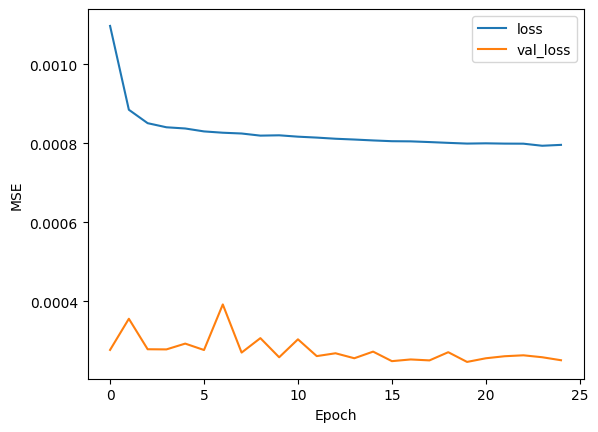

In [33]:
#Graficamos el MSE
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')

## Prediciones
Dado que el test set de muy grande vamos a dividirlo en 7 parte y analizar las por separado

In [34]:
# Calculamos los indices y numero de velas de cada una se las partes en la que vamos a dividir el test set
num_parts = 7
test_set_size = len(data) - index["start_test"]
candles_per_part = test_set_size // num_parts
print(f'Numero de velas de cada parte: {candles_per_part}')
start_index = []

for i in range(num_parts):
    start_index.append(index["start_test"] + i * candles_per_part)    
    print(f'Parte {i+1}: Indice inicial: {start_index[i]}')

# Calculamos el numero de velas de la ultima parte
candles_last_part = test_set_size - (num_parts-1) * candles_per_part
print(f'Numero de velas de la ultima parte: {candles_last_part}')

Numero de velas de cada parte: 2025
Parte 1: Indice inicial: 127596
Parte 2: Indice inicial: 129621
Parte 3: Indice inicial: 131646
Parte 4: Indice inicial: 133671
Parte 5: Indice inicial: 135696
Parte 6: Indice inicial: 137721
Parte 7: Indice inicial: 139746
Numero de velas de la ultima parte: 2027


In [35]:
# Caracteriscas inputs del modelo
features = ['sin_time','cos_time','Open_nor','High_nor','Low_nor','Close_nor','Volume_nor']


In [38]:
tick_size = 0.25
predictions = []
real = []
dif_ticks = []
atr = []
time = []
mape = []
distributions = []
for i in range(num_parts):
    print(f'Parte {i+1} de {num_parts}')    
    candles = candles_per_part
    start_index_part = start_index[i]
    predictions_part, real_part, dif_ticks_part, atr_part, time_part, mape_part, distribution_part, num_out_of_range = mlpd.predict_candle_range(
        start_index = start_index_part, 
        candles = candles,
        seq_length = seq_length, 
        tick_size = tick_size,
        digits = 2,
        model = model, 
        data = data, 
        features = features, 
        features_time = features_time,
        features_price = features_price,
        features_volume = features_volume,
        #features_vp = features_vp,
        normalization_values = normalization_values,  
        value='High',
        period=10, 
        model_type='transformer',
    )
    predictions.append(predictions_part)
    real.append(real_part)
    dif_ticks.append(dif_ticks_part)
    atr.append(atr_part)
    time.append(time_part)
    mape.append(mape_part)
    distributions.append(distribution_part)
    print(f'Parte {i+1}: Numero de veces que la prediccion no es compatible con el open: {num_out_of_range}')
    print('-'*100)

Parte 1 de 7
Parte 1: Numero de veces que la prediccion no es compatible con el open: 407
----------------------------------------------------------------------------------------------------
Parte 2 de 7
Parte 2: Numero de veces que la prediccion no es compatible con el open: 455
----------------------------------------------------------------------------------------------------
Parte 3 de 7
Parte 3: Numero de veces que la prediccion no es compatible con el open: 352
----------------------------------------------------------------------------------------------------
Parte 4 de 7
Parte 4: Numero de veces que la prediccion no es compatible con el open: 432
----------------------------------------------------------------------------------------------------
Parte 5 de 7
Parte 5: Numero de veces que la prediccion no es compatible con el open: 241
----------------------------------------------------------------------------------------------------
Parte 6 de 7
Parte 6: Numero de veces que la 

## Graficas

In [39]:
for i in range(num_parts):
    # Predicciones
    fig_predictions = mlplt.plotly_predictions(real[i], predictions[i])
    fig_predictions.show()

    # Diferencia de ticks
    fig_dif_ticks = mlplt.plotly_dif_ticks_deviation_points_with_ATR(dif_ticks[i],atr[i])
    fig_dif_ticks.show()

    # Scatter
    fig_scatter = mlplt.plotly_dispersion_scatter(atr[i],dif_ticks[i],'Relacion entre ATR y Diferencia de Ticks','ATR','Diferencia de ticks')
    fig_scatter.show()

    # Normal distribution
    fig_normal_distribution = mlplt.plotly_normal_distribution(dif_ticks[i])
    fig_normal_distribution.show()